# Step 1 — Gathering and Exploring the data

In [2]:
#this allows us to read in the data and work with dataframes and work with arrays, 
import pandas as pd
import numpy as np
import seaborn as sns

#import our plotting libraries
%matplotlib inline
import matplotlib as mpl 
import matplotlib.pyplot as plt
import scipy.stats as stats
plt.style.use('ggplot')

#read in the entire house dataset,
house_df = pd.read_csv('train.csv')

#outputs the no of rows and columns in the dataset,
print('=> The number of rows and columns in our dataset is (rows, columns):')
print(house_df.shape,'\n')

#outputs the columns header,
print('=> A sample of the column headers in the dataset are:')
print(house_df.iloc[:,2:8].columns.values)

#outputs the summary statistics and info,
print('\n=> These are the summary statistics for a sample of the columns:\n')
print(house_df.iloc[:,71:].describe())
print('\n=> These are the info for a sample of the columns:\n')
print(house_df.iloc[:,71:80].info())

=> The number of rows and columns in our dataset is (rows, columns):
(1460, 81) 

=> A sample of the column headers in the dataset are:
['MSZoning' 'LotFrontage' 'LotArea' 'Street' 'Alley' 'LotShape']

=> These are the summary statistics for a sample of the columns:

          PoolArea       MiscVal       MoSold       YrSold      SalePrice
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890
std      40.177307    496.123024     2.703626     1.328095   79442.502883
min       0.000000      0.000000     1.000000  2006.000000   34900.000000
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000

=> These are the info for a sample of the columns:

<class 'panda

# Exploring the Data Visually and Descriptive Statistics

in reality, examining every piece of data prior to inclusion into the model is needed

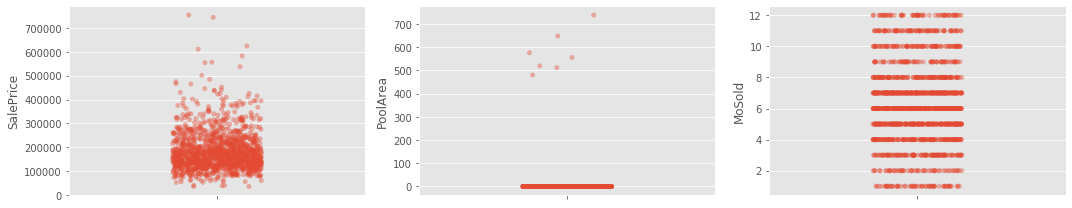

In [3]:
sample_df = house_df[['SalePrice', 'PoolArea','MoSold']]
plt.figure(figsize=(15, 3))

#function for plotting stripplots given a dataframe
def stripplot_these(df):
    for idx, name in enumerate(df.columns):
        n = idx + 1
        plt.subplot(1,3,n)
        sns.stripplot(x=name, data=df, jitter=0.15, orient= 'v', alpha=.4)
    plt.tight_layout()
    plt.show()

stripplot_these(sample_df)

With data that contains many different variables, plotting the variables to understand the distribution and characteristic would make spotting trends or patterns simpler

Regression models cannot work with ‘categorical’ type variables e.g. labels like ‘Hot’or ‘Cold’ instead of 33c or 15c.

The plot of our prediciton variable (Sale Price) looks to contain outliers (values which are outside the normal range of values) this could pose a problem to the model as regression models work by finding the ‘line of best fit’ through all the data, the model might be unfairly influence by these outliers.
Plotting the probability distribution of the Sale Price will help us validate this further.


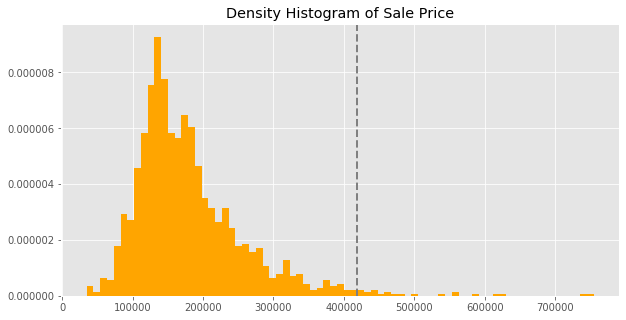

In [4]:
#plotting histogram of values with density values and outlier threshold 
mu = house_df.SalePrice.mean()
sd = house_df.SalePrice.std()
li = mu + 3 * sd
plt.figure(figsize=(10, 5))
plt.title('Density Histogram of Sale Price')
plt.hist(house_df.SalePrice, bins=75,density=True,color='orange')
plt.axvline(li, color='grey', linestyle='dashed', linewidth=2)
plt.show()

# Step 2 — Data Preperation

We won’t go into the programming efforts of transforming all the data here and instead list some of the ‘tricky’ questions which the data scientist would need to answer during this process,
-If product prices are missing, should we use an average value or fill it with the last known values?
-If gender labels are missing, should we fill with the most frequent gender or least frequent?
-If day of months data is missing, should we fill with the first, last, middle day of month?
-Are all variables in the correct data type? Are dates recorded as strings instead of datetime?

# Working Dataset

In [5]:

#list of column names to keep
col_names = ['SalePrice','OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea']

#creating new filtered dataframe
new_df =  house_df[col_names]

#print the new shape of the data,
print('The current number of rows and columns is:\n')
print(new_df.shape)
print('\nWe have reduce the number of variables from 81 to', new_df.shape[1],'\n')

#checking summary statistics and info of new dataframe
print(new_df.info())

The current number of rows and columns is:

(1460, 5)

We have reduce the number of variables from 81 to 5 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 5 columns):
SalePrice      1460 non-null int64
OverallQual    1460 non-null int64
GrLivArea      1460 non-null int64
GarageCars     1460 non-null int64
GarageArea     1460 non-null int64
dtypes: int64(5)
memory usage: 57.1 KB
None


# Checking for Multicollinearity

Multicollinearity is when two variables are highly correlated, for example:
- Individuals height and weight are positively correlated
- Age of motor vehicles and the sales price is negatively correlated

Multicollinearity is a big problem in regression models, if present it causes regression models to be very sensitive and decreases the precision of the model.

We can check for evidence of Multicollinearity using a correlation heat map. Correlation values range between -1 and 1.

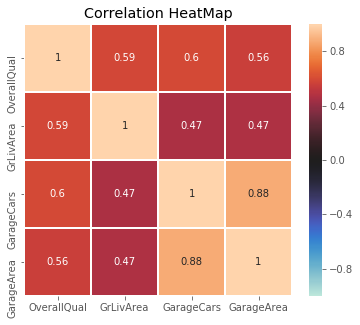

In [6]:
#filtering the dataframe to include just the IV's (features) and another with just the DV's (target)
features = new_df.loc[:,new_df.columns != 'SalePrice']
targets = new_df.loc[:,new_df.columns == 'SalePrice']

#creating pairwise correlation of columns using Pearson's R,
corr = features.corr(method='pearson') 

#plotting the correlation coefficients on a seasborn heatmap matrix
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(corr, annot=True, xticklabels=corr.columns, 
            yticklabels=corr.columns, ax=ax, linewidths=.5, 
            vmin = -1, vmax=1, center=0)

plt.title('Correlation HeatMap')
plt.show()

# Step 3 — Splitting the Data